In [10]:
import pandas as pd
df = pd.read_excel("2024 Comment Report.xlsx")   # or read_excel()
df.head()


,Ship Class,COMMENTS
0,Breakaway Class,Overall cruise expetience was Good. Food in th...
1,Breakaway Class,The ship is showing its age and should have be...
2,Breakaway Class,"did not like that therwas no general seating ,"
3,Breakaway Class,My balcony ststeroom was gross. It smelled dus...
4,Breakaway Class,Because I had a smell in my room. And all the ...


In [11]:
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414991 entries, 0 to 414990
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Ship Class  414991 non-null  object
 1   COMMENTS    414709 non-null  object
dtypes: object(2)
memory usage: 6.3+ MB


,0
Ship Class,0
COMMENTS,282


In [12]:
# Drop rows where COMMENTS is missing
df = df.dropna(subset=['COMMENTS'])

# Verify again
df.isnull().sum()


,0
Ship Class,0
COMMENTS,0


In [13]:
df = df.rename(columns={
    'Ship Class': 'class',
    'COMMENTS': 'comment_text'
})

df.head()


,class,comment_text
0,Breakaway Class,Overall cruise expetience was Good. Food in th...
1,Breakaway Class,The ship is showing its age and should have be...
2,Breakaway Class,"did not like that therwas no general seating ,"
3,Breakaway Class,My balcony ststeroom was gross. It smelled dus...
4,Breakaway Class,Because I had a smell in my room. And all the ...


In [14]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 414709 entries, 0 to 414990
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   class         414709 non-null  object
 1   comment_text  414709 non-null  object
dtypes: object(2)
memory usage: 9.5+ MB


In [15]:
import re

# 1) Make sure comment_text is string
df['comment_text'] = df['comment_text'].astype(str)

# 2) Basic cleaning
df['clean_text'] = (
    df['comment_text']
      .str.lower()                           # lowercase
      .str.replace(r'\s+', ' ', regex=True)  # collapse extra spaces
      .str.strip()                           # trim ends
)

# 3) Remove URLs, emails (common in feedback)
df['clean_text'] = df['clean_text'].str.replace(r'http\S+|www\.\S+', '', regex=True)
df['clean_text'] = df['clean_text'].str.replace(r'\S+@\S+', '', regex=True)

# 4) Remove punctuation/symbols but keep letters and spaces
df['clean_text'] = df['clean_text'].apply(lambda x: re.sub(r"[^a-z\s]", " ", x))

# 5) Final space cleanup
df['clean_text'] = df['clean_text'].str.replace(r'\s+', ' ', regex=True).str.strip()

# Quick check
df[['comment_text', 'clean_text']].head(10)


,comment_text,clean_text
0,Overall cruise expetience was Good. Food in th...,overall cruise expetience was good food in the...
1,The ship is showing its age and should have be...,the ship is showing its age and should have be...
2,"did not like that therwas no general seating ,",did not like that therwas no general seating
3,My balcony ststeroom was gross. It smelled dus...,my balcony ststeroom was gross it smelled dust...
4,Because I had a smell in my room. And all the ...,because i had a smell in my room and all the t...
5,We had great service at the bars and restauran...,we had great service at the bars and restauran...
6,Generally good except for Vibe and paying for ...,generally good except for vibe and paying for ...
7,We thought the entertainment could be enhanced...,we thought the entertainment could be enhanced...
8,"Staff and personnel were very friendly, helpfu...",staff and personnel were very friendly helpful...
9,Staff go above and beyond. Work very hard and ...,staff go above and beyond work very hard and h...


In [16]:
# How many cleaned comments became empty?
(df['clean_text'] == '').sum()


np.int64(207)

In [17]:
# Drop rows where clean_text is empty
df = df[df['clean_text'] != '']

# Verify
(df['clean_text'] == '').sum()


np.int64(0)

In [18]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [19]:
df['sentiment_score'] = df['clean_text'].apply(
    lambda x: sia.polarity_scores(x)['compound']
)

df[['clean_text', 'sentiment_score']].head(10)


,clean_text,sentiment_score
0,overall cruise expetience was good food in the...,0.7709
1,the ship is showing its age and should have be...,-0.0518
2,did not like that therwas no general seating,-0.5122
3,my balcony ststeroom was gross it smelled dust...,0.9724
4,because i had a smell in my room and all the t...,-0.6765
5,we had great service at the bars and restauran...,0.9559
6,generally good except for vibe and paying for ...,0.7351
7,we thought the entertainment could be enhanced...,0.8713
8,staff and personnel were very friendly helpful...,0.9626
9,staff go above and beyond work very hard and h...,0.8467


In [20]:

df.columns


Index(['class', 'comment_text', 'clean_text', 'sentiment_score'], dtype='object')

In [21]:
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_score'].apply(label_sentiment)


In [22]:
df[['sentiment_score', 'sentiment_label']].head(5)


,sentiment_score,sentiment_label
0,0.7709,Positive
1,-0.0518,Negative
2,-0.5122,Negative
3,0.9724,Positive
4,-0.6765,Negative


In [23]:
df['sentiment_label'].value_counts(normalize=True) * 100


,proportion
sentiment_label,
Positive,65.038528
Negative,28.586593
Neutral,6.374879


In [25]:
avg_sentiment = (
    df.groupby('class')['sentiment_score']
      .mean()
      .sort_values(ascending=False)
      .reset_index()
)

avg_sentiment


,class,sentiment_score
0,Prima Class,0.377089
1,Breakaway Class,0.334991
2,Jewel Class,0.330966
3,PoA Class,0.309283
4,Spirit Class,0.294841
5,Sun Class,0.288622
6,Epic Class,0.191715
7,Dawn Class,0.102514


In [26]:
neg_pct = (
    (df['sentiment_label'] == 'Negative')
    .groupby(df['class'])
    .mean()
    .mul(100)
    .sort_values(ascending=False)
    .reset_index(name='negative_pct')
)

neg_pct


,class,negative_pct
0,Dawn Class,41.449127
1,Epic Class,35.546593
2,Sun Class,29.973785
3,Spirit Class,29.076621
4,PoA Class,27.924733
5,Jewel Class,27.350344
6,Breakaway Class,26.875642
7,Prima Class,24.771365


In [27]:
summary = avg_sentiment.merge(neg_pct, on='class')
summary


,class,sentiment_score,negative_pct
0,Prima Class,0.377089,24.771365
1,Breakaway Class,0.334991,26.875642
2,Jewel Class,0.330966,27.350344
3,PoA Class,0.309283,27.924733
4,Spirit Class,0.294841,29.076621
5,Sun Class,0.288622,29.973785
6,Epic Class,0.191715,35.546593
7,Dawn Class,0.102514,41.449127


In [31]:
summary.to_csv("ncl_sentiment_summary_by_class.csv", index=False)


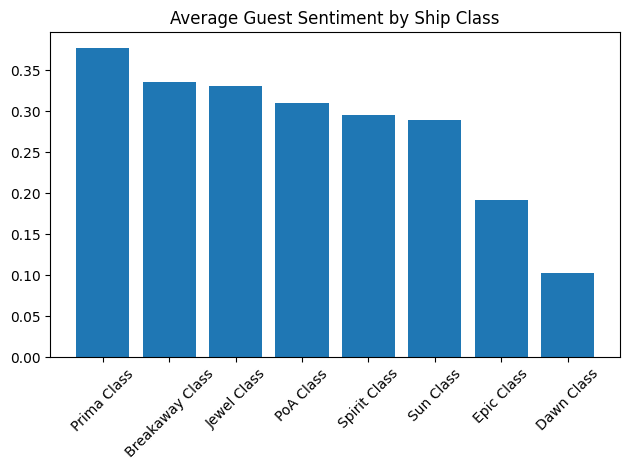

In [32]:
import matplotlib.pyplot as plt

plt.bar(summary['class'], summary['sentiment_score'])
plt.xticks(rotation=45)
plt.title("Average Guest Sentiment by Ship Class")
plt.tight_layout()
plt.show()


Analysis 2: Theme/Driver Analysis

In [33]:
df.columns


Index(['class', 'comment_text', 'clean_text', 'sentiment_score',
       'sentiment_label'],
      dtype='object')

In [34]:
def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment_label'] = df['sentiment_score'].apply(label_sentiment)


In [37]:
neg_df = df[df['sentiment_label'] == 'Negative'].copy()
neg_df.shape


(118492, 5)

In [41]:
import nltk

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [42]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))

def tokenize_clean(text):
    tokens = word_tokenize(text)
    return [w for w in tokens if w not in stop_words and len(w) > 2]

neg_df['tokens'] = neg_df['clean_text'].apply(tokenize_clean)

neg_df[['clean_text', 'tokens']].head(3)


,clean_text,tokens
1,the ship is showing its age and should have be...,"[ship, showing, age, scheduled, refurb, earlie..."
2,did not like that therwas no general seating,"[like, therwas, general, seating]"
4,because i had a smell in my room and all the t...,"[smell, room, things, tried, work, nothing, el..."


In [43]:
from collections import Counter

all_words = [w for tokens in neg_df['tokens'] for w in tokens]
Counter(all_words).most_common(20)


[('cruise', 68337),
 ('ship', 50785),
 ('food', 47857),
 ('room', 37791),
 ('time', 37109),
 ('get', 35227),
 ('staff', 34965),
 ('service', 33459),
 ('ncl', 31507),
 ('one', 29597),
 ('would', 28929),
 ('day', 27729),
 ('people', 24695),
 ('good', 22545),
 ('poor', 21494),
 ('could', 21266),
 ('experience', 21263),
 ('also', 20548),
 ('many', 19328),
 ('never', 19165)]

In [44]:
from collections import Counter

all_words = [w for tokens in neg_df['tokens'] for w in tokens]
top_words = Counter(all_words).most_common(20)
top_words


[('cruise', 68337),
 ('ship', 50785),
 ('food', 47857),
 ('room', 37791),
 ('time', 37109),
 ('get', 35227),
 ('staff', 34965),
 ('service', 33459),
 ('ncl', 31507),
 ('one', 29597),
 ('would', 28929),
 ('day', 27729),
 ('people', 24695),
 ('good', 22545),
 ('poor', 21494),
 ('could', 21266),
 ('experience', 21263),
 ('also', 20548),
 ('many', 19328),
 ('never', 19165)]

In [45]:
themes = {
    'Food & Dining': ['food', 'buffet', 'restaurant', 'dining', 'meal', 'breakfast', 'lunch', 'dinner'],
    'Service Quality': ['service', 'staff', 'crew', 'manager', 'rude', 'helpful', 'attitude'],
    'Crowding & Wait Times': ['wait', 'line', 'queue', 'crowded', 'busy', 'reservation'],
    'Cabin Experience': ['room', 'cabin', 'bed', 'noise', 'balcony', 'bathroom', 'air', 'ac'],
    'Cleanliness': ['dirty', 'clean', 'smell', 'stain', 'filthy', 'mold'],
    'Value for Money': ['price', 'worth', 'overpriced', 'cost', 'expensive', 'value'],
    'Internet & App': ['wifi', 'internet', 'app', 'connection'],
    'Excursions & Ports': ['excursion', 'port', 'shore', 'tender']
}


In [46]:
import pandas as pd

def assign_themes(tokens):
    result = {theme: 0 for theme in themes}
    token_set = set(tokens)
    for theme, keywords in themes.items():
        result[theme] = sum(1 for k in keywords if k in token_set)
    return result

theme_matrix = neg_df['tokens'].apply(assign_themes).apply(pd.Series)
theme_matrix.head()


,Food & Dining,Service Quality,Crowding & Wait Times,Cabin Experience,Cleanliness,Value for Money,Internet & App,Excursions & Ports
1,1,0,0,2,1,0,0,1
2,0,0,0,0,0,0,0,0
4,0,0,0,2,1,0,0,0
16,1,0,0,0,0,0,0,0
19,0,2,0,0,0,0,0,0


In [47]:
theme_by_class = (
    pd.concat([neg_df[['class']], theme_matrix], axis=1)
      .groupby('class')
      .sum()
)

theme_by_class



,Food & Dining,Service Quality,Crowding & Wait Times,Cabin Experience,Cleanliness,Value for Money,Internet & App,Excursions & Ports
class,,,,,,,,
Breakaway Class,33745,26650,12749,19374,3478,6172,6757,11373
Dawn Class,7184,5642,1853,3821,614,1733,1704,4108
Epic Class,7279,6489,4011,6817,1238,1197,1349,3080
Jewel Class,13357,10100,3677,7910,1208,2424,3243,4658
PoA Class,4772,3331,826,2272,532,1055,614,1278
Prima Class,8507,5914,2726,4116,436,1629,1244,2081
Spirit Class,1318,867,241,701,81,371,295,589
Sun Class,6037,3778,1061,3360,601,957,1385,1663


In [48]:
from google.colab import sheets
sheet = sheets.InteractiveSheet(df=theme_by_class)

https://docs.google.com/spreadsheets/d/1MRnm4kEKA326JvJx_cZwU2kDcHP4h2hkNyQRkkwZTxU/edit#gid=0


In [49]:
theme_pct_by_class = (theme_by_class.div(theme_by_class.sum(axis=1), axis=0) * 100).round(2)
theme_pct_by_class


,Food & Dining,Service Quality,Crowding & Wait Times,Cabin Experience,Cleanliness,Value for Money,Internet & App,Excursions & Ports
class,,,,,,,,
Breakaway Class,28.05,22.15,10.60,16.11,2.89,5.13,5.62,9.45
Dawn Class,26.95,21.16,6.95,14.33,2.30,6.50,6.39,15.41
Epic Class,23.14,20.63,12.75,21.67,3.94,3.80,4.29,9.79
Jewel Class,28.68,21.68,7.89,16.98,2.59,5.20,6.96,10.00
PoA Class,32.51,22.69,5.63,15.48,3.62,7.19,4.18,8.71
Prima Class,31.92,22.19,10.23,15.44,1.64,6.11,4.67,7.81
Spirit Class,29.53,19.43,5.40,15.71,1.81,8.31,6.61,13.20
Sun Class,32.04,20.05,5.63,17.83,3.19,5.08,7.35,8.83


from matplotlib import pyplot as plt
theme_pct_by_class['Food & Dining'].plot(kind='hist', bins=20, title='Food & Dining')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
theme_pct_by_class['Service Quality'].plot(kind='hist', bins=20, title='Service Quality')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
theme_pct_by_class['Crowding & Wait Times'].plot(kind='hist', bins=20, title='Crowding & Wait Times')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
theme_pct_by_class['Cabin Experience'].plot(kind='hist', bins=20, title='Cabin Experience')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
theme_pct_by_class.plot(kind='scatter', x='Food & Dining', y='Service Quality', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
theme_pct_by_class.plot(kind='scatter', x='Service Quality', y='Crowding & Wait Times', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
theme_pct_by_class.plot(kind='scatter', x='Crowding & Wait Times', y='Cabin Experience', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
theme_pct_by_class.plot(kind='scatter', x='Cabin Experience', y='Cleanliness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
theme_pct_by_class['Food & Dining'].plot(kind='line', figsize=(8, 4), title='Food & Dining')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
theme_pct_by_class['Service Quality'].plot(kind='line', figsize=(8, 4), title='Service Quality')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
theme_pct_by_class['Crowding & Wait Times'].plot(kind='line', figsize=(8, 4), title='Crowding & Wait Times')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
theme_pct_by_class['Cabin Experience'].plot(kind='line', figsize=(8, 4), title='Cabin Experience')
plt.gca().spines[['top', 'right']].set_visible(False)

In [50]:
top3_drivers = theme_pct_by_class.apply(
    lambda row: row.sort_values(ascending=False).head(3),
    axis=1
)

top3_drivers


,Cabin Experience,Excursions & Ports,Food & Dining,Service Quality
class,,,,
Breakaway Class,16.11,NaN,28.05,22.15
Dawn Class,NaN,15.41,26.95,21.16
Epic Class,21.67,NaN,23.14,20.63
Jewel Class,16.98,NaN,28.68,21.68
PoA Class,15.48,NaN,32.51,22.69
Prima Class,15.44,NaN,31.92,22.19
Spirit Class,15.71,NaN,29.53,19.43
Sun Class,17.83,NaN,32.04,20.05
